## Divvy Bike Data<br>
<br>

The objective of this part of the project is to help the Mayor of Chicago to better understand the ridership of Divvy Bike, a Chicago's bike-sharing system that has continued to grow since its birth in 2013. Furthermore, the mayor is hoping to boost Divvy Bike’s feasibility by adding the trip duration feature into their system. Thus, besides exploratory data analysis, we would build a predictive model which take the start station and destination station as input and return the prediction of trip duration as result.<br>

To run this notebook, you have to first read in the Divvy_Trips_Model.csv file, which is the output from the divvy_eda_ts notebook.<br>

The packages require for modeling include: pandas, numpy, matplotlib, seaborn. LinearRegression,Ridge,Lasso,RidgeCV,LassoCV, ElasticNet, ElasticNetCV for linear model; RandomForestRegressor, xbgoost for the ensemble method; statsmodels.api to build the stepwise feature selection function; train_test_split, GridSearchCV for the model selection and last the mean_squared_error, r2_score and accuracy_score for model performance.<br>

Last, you'll need the geopy package for the user interface prototype which connect the final model to predict the tripduration.<br>

In [451]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost
import statsmodels.api as sm

from geopy.distance import distance

import warnings
warnings.filterwarnings("ignore")

#### Read in dataset

In [ ]:
df = pd.read_csv('Divvy_Trips_Model.csv', parse_dates = ['start_time','end_time'])
df.head()

In [ ]:
df.columns

### First Try<br>
In the first try, we'll put all the features below into the model: OLS regression, lasso regression, ridge, elastic net and random forest. Also, we'll reference the correlation of features and the results of stepwise feature selection to select our features.

In [284]:
X = df.loc[:,['age','from_latitude','from_longitude','to_latitude','to_longitude',
              'log_dis_travel','speed','month','day','hour','weekend','holiday','TAVG',
              'user_Customer','user_Subscriber','gender_Female','gender_Male']]
y = df.log_tripduration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5) # 70% train, 30% test

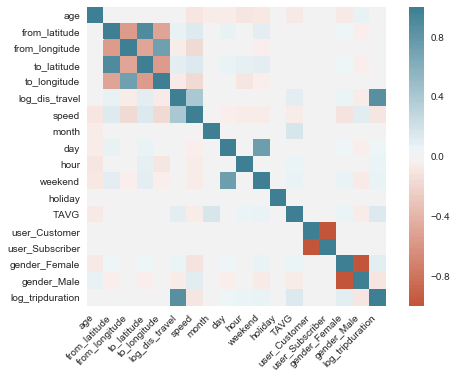

In [240]:
# plot correlation heatmap
corr = pd.concat([X, y], axis=1).corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),square=True)


ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right');

#### Linear Regression

In [241]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_train,y_train) #return model R^2

0.9633152908879883

#### Lasso Regression

In [242]:
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso.score(X_train,y_train) #return train set R^2

0.9631550083811475

#### Ridge

In [243]:
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
ridge.score(X_train, y_train) #return train set R^2

0.9633152907519587

#### Elastic Net

In [244]:
elastic = ElasticNetCV(cv=5, random_state=0).fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
elastic.score(X_train, y_train)#return train set R^2

0.9631122569783257

#### Random Forest

In [259]:
# Use GridSerachCV to tune the max_depth parameater. 
parameter_candidates = {'max_depth': np.arange(2, 5, 1)}

rf = RandomForestRegressor(random_state=0)
rfgs = GridSearchCV(estimator=rf, param_grid=parameter_candidates)
rfgs.fit(X_train, y_train) 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([2, 3, 4])

In [260]:
print (rfgs.best_params_) # report best parameter given by CV
print (rfgs.best_score_)

{'max_depth': 4}
0.8867550658042688


In [262]:
rf = RandomForestRegressor(random_state=0,max_depth=4) # build a model base on best parameter
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [263]:
# the test set accuracy
accuracy = pd.DataFrame([r2_score(y_test,y_pred),mean_squared_error(y_test, y_pred)**(0.5)],
                        columns = ['linear'],index=['R^2','RMSE'])
accuracy['lasso'] = [r2_score(y_test,y_pred_lasso),mean_squared_error(y_test, y_pred_lasso)**(0.5)]
accuracy['ridge'] = [r2_score(y_test,y_pred_ridge),mean_squared_error(y_test, y_pred_ridge)**(0.5)]
accuracy['elastic'] = [r2_score(y_test,y_pred_elastic),mean_squared_error(y_test, y_pred_elastic)**(0.5)]
accuracy['rf'] = [r2_score(y_test,y_pred_rf),mean_squared_error(y_test, y_pred_rf)**(0.5)]
accuracy

,linear,lasso,ridge,elastic,rf
R^2,0.964489,0.964340,0.964489,0.964297,0.885014
RMSE,0.120805,0.121059,0.120805,0.121132,0.217384


In [264]:
# coefficient of linear model and feature importance of random forest
linear = pd.DataFrame(reg.coef_, index=X.columns, columns=['linear'])
linear['lasso'] = lasso.coef_
linear['ridge'] = ridge.coef_
linear['elastic'] = elastic.coef_
linear['rf'] = rf.feature_importances_
linear

,linear,lasso,ridge,elastic,rf
age,-0.000274,-2.298662e-04,-0.000274,-0.000222,0.000000
from_latitude,0.037294,0.000000e+00,0.037494,0.000000,0.000000
from_longitude,-0.148447,-0.000000e+00,-0.147977,-0.000000,0.000000
to_latitude,0.093066,0.000000e+00,0.092852,0.000000,0.000000
to_longitude,0.072140,-0.000000e+00,0.071701,-0.000000,0.000000
log_dis_travel,0.997083,9.928338e-01,0.997082,0.989253,0.815932
speed,-0.180227,-1.784744e-01,-0.180227,-0.177845,0.184068
month,-0.000149,-1.553173e-05,-0.000149,-0.000027,0.000000
day,-0.000228,1.330496e-03,-0.000228,0.001372,0.000000
hour,0.000249,2.693519e-04,0.000249,0.000291,0.000000


#### Stepwise Feature Selection.
Since sklearn does not provide package for stepwise feature selection, we write our own function to implement.

In [250]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.001, 
                       threshold_out = 0.01, 
                       verbose=True):
    """ 
    This function perform a forward-backward feature selection based on p-value from statsmodels.api.OLS
    It will return a list of selected features.
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
         
    Notice: threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X_train, y_train)

print('resulting features:')
print(result)

Add  speed                          with p-value 0.0
Add  from_latitude                  with p-value 0.0
Add  gender_Female                  with p-value 0.0
Add  weekend                        with p-value 0.0
Add  to_latitude                    with p-value 0.0
Add  gender_Male                    with p-value 0.0
Add  hour                           with p-value 0.0
Add  TAVG                           with p-value 0.0
Add  age                            with p-value 0.0
Add  log_dis_travel                 with p-value 0.0
Add  from_longitude                 with p-value 6.44119e-110
Add  to_longitude                   with p-value 1.76359e-33
Add  month                          with p-value 1.2869e-06
Add  user_Customer                  with p-value 0.000234986
Add  user_Subscriber                with p-value 1.37748e-111
Add  day                            with p-value 0.00069209
resulting features:
['speed', 'from_latitude', 'gender_Female', 'weekend', 'to_latitude', 'gender_Male',

Referring to the features correlation and the results from all the shrinkage method we did above.<br>
We will improve the model by excluding some features.<br>
latitude, longitude, month,holiday, usertypes, gender_Male

### Second Try

In [298]:
X = df.loc[:,['age','log_dis_travel','month','day','hour','TAVG','gender_Female']]
y = df.log_tripduration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [270]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_train,y_train) #return model R^2

0.7463123179550324

In [271]:
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso.score(X_train,y_train) #return train set R^2

0.746278922648685

In [272]:
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
ridge.score(X_train, y_train) #return train set R^2

0.7463123179542008

In [273]:
elastic = ElasticNetCV(cv=5, random_state=0).fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
elastic.score(X_train, y_train)#return train set R^2

0.7462549882346015

In [274]:
rf = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test)

In [275]:
# test set accuracy
accuracy = pd.DataFrame([r2_score(y_test,y_pred),mean_squared_error(y_test, y_pred)**(0.5)],
                        columns = ['linear'],index=['R^2','RMSE'])
accuracy['lasso'] = [r2_score(y_test,y_pred_lasso),mean_squared_error(y_test, y_pred_lasso)**(0.5)]
accuracy['ridge'] = [r2_score(y_test,y_pred_ridge),mean_squared_error(y_test, y_pred_ridge)**(0.5)]
accuracy['elastic'] = [r2_score(y_test,y_pred_elastic),mean_squared_error(y_test, y_pred_elastic)**(0.5)]
accuracy['rf'] = [r2_score(y_test,y_pred_rf),mean_squared_error(y_test, y_pred_rf)**(0.5)]
accuracy

,linear,lasso,ridge,elastic,rf
R^2,0.748328,0.748287,0.748328,0.748258,0.738838
RMSE,0.321605,0.321631,0.321605,0.321650,0.327613


Notice the test error and model R^2 is worse the firt try, but at least the features are not correlated now.

In [276]:
linear = pd.DataFrame(reg.coef_, index=X.columns, columns=['linear'])
linear['lasso'] = lasso.coef_
linear['ridge'] = ridge.coef_
linear['elastic'] = elastic.coef_
linear['rf'] = rf.feature_importances_
linear

,linear,lasso,ridge,elastic,rf
age,0.003374,0.003330,0.003374,0.003324,0.000000
log_dis_travel,0.795557,0.792856,0.795556,0.790576,0.999303
month,0.000074,0.000000,0.000074,0.000000,0.000000
day,0.010574,0.010265,0.010574,0.010275,0.000000
hour,0.005320,0.005259,0.005320,0.005261,0.000000
TAVG,0.002010,0.002030,0.002010,0.002040,0.000697
gender_Female,0.091478,0.084419,0.091478,0.083956,0.000000


Text(0.5, 1.0, 'Random Forest Cumulative Features Importance')

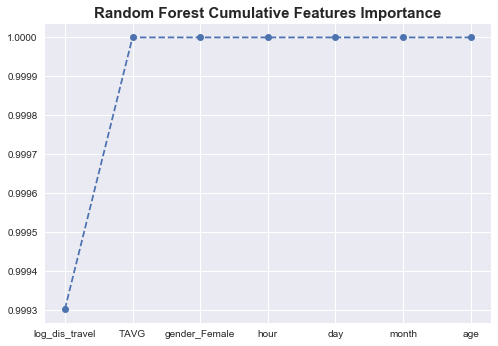

In [504]:
# plot cumulativce feature importance by random forest
plt.plot(np.cumsum(linear.rf.sort_values(ascending = False)), linestyle='--', marker='o')
plt.title('Random Forest Cumulative Features Importance', fontsize = 15, weight = 'bold')

### Third Try
Referencing the random forest feature importance, we only keep the distance (log_dis_travel) and average temparature (TAVG) two features in the model.

In [306]:
X = df.loc[:,['log_dis_travel','TAVG']]
y = df.log_tripduration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [307]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_tr = reg.predict(X_train)
reg.score(X_train,y_train) #return model R^2

0.7377939952634884

In [308]:
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
y_pred_lassotr = lasso.predict(X_train)
lasso.score(X_train,y_train) #return train set R^2

0.7377845534783003

In [309]:
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_pred_ridgetr = ridge.predict(X_train)
ridge.score(X_train, y_train) #return train set R^2

0.7377939952634724

In [310]:
elastic = ElasticNetCV(cv=5, random_state=0).fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
y_pred_elastictr = elastic.predict(X_train)
elastic.score(X_train, y_train)#return train set R^2

0.7377635913763734

In [311]:
rf = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rftr = rf.predict(X_train)

In [313]:
# the train set accuracy
accuracy = pd.DataFrame([r2_score(y_train,y_pred_tr),mean_squared_error(y_train, y_pred_tr)**(0.5)],
                        columns = ['linear'],index=['R^2','RMSE'])
accuracy['lasso'] = [r2_score(y_train,y_pred_lassotr),mean_squared_error(y_train, y_pred_lassotr)**(0.5)]
accuracy['ridge'] = [r2_score(y_train,y_pred_ridgetr),mean_squared_error(y_train, y_pred_ridgetr)**(0.5)]
accuracy['elastic'] = [r2_score(y_train,y_pred_elastictr),mean_squared_error(y_train, y_pred_elastictr)**(0.5)]
accuracy['rf'] = [r2_score(y_train,y_pred_rftr),mean_squared_error(y_train, y_pred_rftr)**(0.5)]
accuracy

,linear,lasso,ridge,elastic,rf
R^2,0.737794,0.737785,0.737794,0.737764,0.737136
RMSE,0.328490,0.328496,0.328490,0.328509,0.328902


In [312]:
# the test set accuracy
accuracy = pd.DataFrame([r2_score(y_test,y_pred),mean_squared_error(y_test, y_pred)**(0.5)],
                        columns = ['linear'],index=['R^2','RMSE'])
accuracy['lasso'] = [r2_score(y_test,y_pred_lasso),mean_squared_error(y_test, y_pred_lasso)**(0.5)]
accuracy['ridge'] = [r2_score(y_test,y_pred_ridge),mean_squared_error(y_test, y_pred_ridge)**(0.5)]
accuracy['elastic'] = [r2_score(y_test,y_pred_elastic),mean_squared_error(y_test, y_pred_elastic)**(0.5)]
accuracy['rf'] = [r2_score(y_test,y_pred_rf),mean_squared_error(y_test, y_pred_rf)**(0.5)]
accuracy

,linear,lasso,ridge,elastic,rf
R^2,0.739858,0.739842,0.739858,0.739815,0.738838
RMSE,0.326972,0.326982,0.326972,0.326999,0.327613


Notice the R^2 and RMSE only slightly worse than second try when using only two features. In terms of interpretability and model complexity, we'll maintain only two features.

### XGboost
Now, let's try to build a xgboost model with only two features.

#### K-fold CV to fine tune xgboost

In [ ]:
##########
## Notice: This cell will take a long time to run!
##########

#params_grid_1 = {'n_estimators': [50,100,150,200]
#          'max_depth':[3, 7, 10, 14], \
#          'learning_rate':[0.05, 0.08, 0.1], \
#          'gamma':[0, 1, 5]
#         }

# From the CV results, these are the parameaters for our final model
#xgb_model = xgboost.XGBRegressor()
#grid_search_m1 = GridSearchCV(estimator=xgb_model, param_grid=params_grid_1, cv=3)
#grid_search_m1.fit(X_train,y_train) 

In [433]:
# the final model with selected parameaters
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgbtr = xgb.predict(X_train)

In [436]:
# the train set accuracy
accuracy = pd.DataFrame([r2_score(y_train,y_pred_tr),mean_squared_error(y_train, y_pred_tr)**(0.5)],
                        columns = ['linear'],index=['R^2','RMSE'])
accuracy['lasso'] = [r2_score(y_train,y_pred_lassotr),mean_squared_error(y_train, y_pred_lassotr)**(0.5)]
accuracy['ridge'] = [r2_score(y_train,y_pred_ridgetr),mean_squared_error(y_train, y_pred_ridgetr)**(0.5)]
accuracy['elastic'] = [r2_score(y_train,y_pred_elastictr),mean_squared_error(y_train, y_pred_elastictr)**(0.5)]
accuracy['rf'] = [r2_score(y_train,y_pred_rftr),mean_squared_error(y_train, y_pred_rftr)**(0.5)]
accuracy['xgboost'] = [r2_score(y_train,y_pred_xgbtr),mean_squared_error(y_train, y_pred_xgbtr)**(0.5)]
accuracy

,linear,lasso,ridge,elastic,rf,xgboost
R^2,0.737794,0.737785,0.737794,0.737764,0.737136,0.758892
RMSE,0.328490,0.328496,0.328490,0.328509,0.328902,0.314997


In [437]:
# the test set accuracy
accuracy = pd.DataFrame([r2_score(y_test,y_pred),mean_squared_error(y_test, y_pred)**(0.5)],
                        columns = ['linear'],index=['R^2','RMSE'])
accuracy['lasso'] = [r2_score(y_test,y_pred_lasso),mean_squared_error(y_test, y_pred_lasso)**(0.5)]
accuracy['ridge'] = [r2_score(y_test,y_pred_ridge),mean_squared_error(y_test, y_pred_ridge)**(0.5)]
accuracy['elastic'] = [r2_score(y_test,y_pred_elastic),mean_squared_error(y_test, y_pred_elastic)**(0.5)]
accuracy['rf'] = [r2_score(y_test,y_pred_rf),mean_squared_error(y_test, y_pred_rf)**(0.5)]
accuracy['xgboost'] = [r2_score(y_test,y_pred_xgb),mean_squared_error(y_test, y_pred_xgb)**(0.5)]
accuracy

,linear,lasso,ridge,elastic,rf,xgboost
R^2,0.739858,0.739842,0.739858,0.739815,0.738838,0.759742
RMSE,0.326972,0.326982,0.326972,0.326999,0.327613,0.314227


In [505]:
print("Accuracy of OLS: %.2f%%" % (reg.score(X_test,y_test) * 100.0))
print("Accuracy of Lasso: %.2f%%" % (lasso.score(X_test,y_test) * 100.0))
print("Accuracy of Ridge: %.2f%%" % (ridge.score(X_test,y_test) * 100.0))
print("Accuracy of Elastic Net: %.2f%%" % (elastic.score(X_test,y_test) * 100.0))
print("Accuracy of Random Forest: %.2f%%" % (rf.score(X_test,y_test) * 100.0))
print("Accuracy of XGBoost: %.2f%%" % (xgb.score(X_test,y_test) * 100.0))

Accuracy of OLS: 73.99%
Accuracy of Lasso: 73.98%
Accuracy of Ridge: 73.99%
Accuracy of Elastic Net: 73.98%
Accuracy of Random Forest: 73.88%
Accuracy of XGBoost: 75.97%


The R^2 and RMSE for xgboost model is slightly better than all linear model and random forest models we tried previously, so I choice it as my finalize model.<br>
Next, I will build a prototype for Divvy Bike showing how they can connect the model and return the predictive trip duration to their customers.

### User Interface Prototype

In [448]:
def trip_duration_predict(df, temp = 74.0):
    """
    This function use the XGBoost model to predict the trip duration.
    The input prompt should be the from and to station name
    It will return the trip distance (miles) and the predictive trip duration (mins)
    """
    from_station_name = input('Where are you now?')
    to_station_name = input('Where are you going?')
    
    from_lat = df.from_latitude[df.from_station_name == from_station_name].iloc[0]
    from_lon = df.from_longitude[df.from_station_name == from_station_name].iloc[0]
    to_lat = df.to_latitude[df.to_station_name == to_station_name].iloc[0]
    to_lon = df.to_longitude[df.to_station_name == to_station_name].iloc[0]
    
    dis = distance(tuple((from_lat, from_lon)),tuple((to_lat, to_lon))).miles
    
    X_pred = pd.DataFrame([[np.log(dis), temp]],columns=['log_dis_travel', 'TAVG'])
    y_pred = np.exp(xgb.predict(X_pred)) #the output of tripduration need to be transform back
    
    print('The distance of this trip is %2f. miles' %(dis))
    print('You will arrive at %2d minutes'%(y_pred))

In [450]:
# We want to travel from Streeter Dr & Grand Ave
# to Theater on the Lake
# Assuming the tempature today is 74 degree

trip_duration_predict(df)

Where are you now?Streeter Dr & Grand Ave
Where are you going?Theater on the Lake
The distance of this trip is 2.538608. miles
You will arrive at 20 minutes
